In [ ]:
# # RAG Setup: loaders, splitter, embeddings, vector store
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

# # 1) Load your PDFs
# pdf_paths = [
#     "../query6_data/Asset allocation.pdf"
# ]

# docs = []
# for p in pdf_paths:
#     loader = PyPDFLoader(p)
#     # Each page comes with metadata; loader returns Document objects
#     docs.extend(loader.load())

# # 2) Split into chunks (keep overlaps for context continuity)
# splitter = RecursiveCharacterTextSplitter(
#     chunk_size=900, chunk_overlap=150, separators=["\n\n", "\n", " ", ""]
# )
# splits = splitter.split_documents(docs)

# # 3) Embeddings (no API key needed)
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# # 4) Build FAISS index
# vecstore = FAISS.from_documents(splits, embeddings)

# # 5) Create a retriever (top_k configurable inside the tool)
# retriever = vecstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})


In [35]:
def faiss_score_to_cosine(distance: float) -> float:
    """
    Convert FAISS L2 distance to cosine similarity.
    Works if embeddings were normalized to unit length.
    """
    return 1 - (distance ** 2) / 2

In [100]:
# 1) Load your PDFs
pdf_paths = [
    "../query1_data/Gold ETF vs Physical Gold.pdf",
    "../query1_data/Sovereign Gold Bond Scheme 2025-26.pdf"
]

docs = []
for p in pdf_paths:
    loader = PyPDFLoader(p)
    # Each page comes with metadata; loader returns Document objects
    docs.extend(loader.load())

# 2) Split into chunks (keep overlaps for context continuity)
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=150, separators=["\n\n", "\n", " ", ""]
)
splits = splitter.split_documents(docs)

# 3) Embeddings (no API key needed)
embeddings = HuggingFaceEmbeddings(
    model_name="intfloat/e5-base-v2",
    encode_kwargs={"normalize_embeddings": True}
)

# 4) Build FAISS index
vecstore = FAISS.from_documents(splits, embeddings)

# 5) Create a retriever (top_k configurable inside the tool)
retriever = vecstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

# Define your query
query = "What are the benefits of Sovereign Gold Bonds compared to physical gold?"

# Search for relevant chunks
retrieved_docs = vecstore.similarity_search(query, k=5)

# Combine retrieved content
# context = "\n\n".join([doc.page_content for doc in retrieved_docs])

# return {"context": ["context"]}
# print(context)

In [101]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# query = "What are the benefits of Sovereign Gold Bonds compared to physical gold?"

# Search for relevant chunks and get the documents
# retrieved_docs = vecstore.similarity_search(query, k=3)

# Get the text content of the retrieved documents
retrieved_texts = [doc.page_content for doc in retrieved_docs]
context = "\n\n".join([doc.page_content for doc in retrieved_docs])
print(retrieved_texts)
print(len(retrieved_texts))
# Get the embeddings for both the query and the retrieved documents
# This is the crucial step to fix the error.
query_embedding = embeddings.embed_query(query)
retrieved_embeddings = embeddings.embed_documents(retrieved_texts)

# Convert embeddings to numpy arrays if they are not already
query_embedding = np.array(query_embedding).reshape(1, -1)
retrieved_embeddings = np.array(retrieved_embeddings)

# Now, combine the query embedding with the document embeddings
all_embeddings = np.vstack([query_embedding, retrieved_embeddings])

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=1, random_state=42, init='pca', learning_rate='auto')
reduced_vectors = tsne.fit_transform(all_embeddings)

# Separate the reduced vectors for plotting
query_vec_2d = reduced_vectors[0]
doc_vecs_2d = reduced_vectors[1:]

# Create a list of labels for the plot
labels = ["Query"] + [f"Doc {i+1}" for i in range(len(doc_vecs_2d))]

# Visualize the results using Plotly for an interactive plot
fig = go.Figure()

# Add a trace for the query
fig.add_trace(go.Scatter(
    x=[query_vec_2d[0]],
    y=[query_vec_2d[1]],
    mode='markers+text',
    name='Query',
    text=['Query'],
    marker=dict(size=10, color='red'),
    textposition="top center"
))

# Add a trace for the retrieved documents
fig.add_trace(go.Scatter(
    x=doc_vecs_2d[:, 0],
    y=doc_vecs_2d[:, 1],
    mode='markers+text',
    name='Retrieved Chunks',
    text=[f"Doc {i+1}" for i in range(len(doc_vecs_2d))],
    marker=dict(size=8, color='blue'),
    textposition="bottom center"
))

# Update layout for a better visual
fig.update_layout(
    title='t-SNE Visualization of FAISS Search Results',
    xaxis_title='t-SNE Dimension 1',
    yaxis_title='t-SNE Dimension 2',
    legend_title='Vectors',
    width=700,  # Set the canvas width to 600 pixels
    height=400  # Set the canvas height to 400 pixels   # Sets the y-axis tick step
)

fig.show()

# To get the scores, you can use similarity_search_with_score
# retrieved_docs_with_scores = vecstore.similarity_search_with_score(query, k=5)
# print(retrieved_docs_with_scores)

# for doc, score in retrieved_docs_with_scores:
#     cosine_sim = faiss_score_to_cosine(score)
#     print("Chunk:", doc.page_content[:80], "...")
#     print("FAISS L2 distance:", score)
#     print("Cosine similarity:", cosine_sim)
#     print()

['What is the Sovereign Gold Bond Scheme?\nThe Sovereign Gold Bond Scheme is a government initiative launched by the Reserve Bank of India (RBI)\non behalf of the Government of India. It allows investors to invest in gold in a non-physical form, making it\na safer and more eﬃcient alternative to buying physical gold. These bonds are denominated in grams of\ngold and oﬀer an annual interest rate of 2.50% over and above the potential capital gains linked to the\nmarket price of gold.', '\ue9009082 | 2 mins  14 April 2025\nThe Sovereign Gold Bond Scheme is a government-backed investment option that enables individuals to\ninvest in gold without the need for physical possession. These bonds oﬀer the dual beneﬁt of annual\ninterest income and returns linked to the market value of gold. With the upcoming Sovereign Gold Bond\nScheme 2024–25, investors will have another opportunity to subscribe at prevailing gold rates,', 'of the biggest advantages of SGBs is the exemption from capital gains t

In [102]:
import numpy as np

# Assuming you have already generated these embeddings
query_embedding = np.array(query_embedding).reshape(1, -1)
retrieved_embeddings = np.array(retrieved_embeddings)

# Reshape the query embedding to be a 1D vector for easier calculation
query_vector = query_embedding[0]

# Calculate dot product and norms
dot_product = np.dot(retrieved_embeddings, query_vector)
norm_docs = np.linalg.norm(retrieved_embeddings, axis=1)
norm_query = np.linalg.norm(query_vector)

# Calculate cosine similarity for each document
cosine_scores = dot_product / (norm_docs * norm_query)

# Now you have an array of cosine scores, one for each retrieved document.
# You can pair these with the documents to sort them.
for i, score in enumerate(cosine_scores):
    print(f"Document {i+1} Cosine Similarity Score: {score}")

# Sort the documents based on their scores in descending order
sorted_indices = np.argsort(cosine_scores)[::-1]
sorted_docs = [retrieved_docs[i] for i in sorted_indices]
sorted_scores = cosine_scores[sorted_indices]

print("\nDocuments ranked by cosine similarity:")
for i in range(len(sorted_docs)):
    print(f"Rank {i+1}: Score = {sorted_scores[i]:.4f}, Document = {sorted_docs[i].page_content[:50]}...")

average_score = np.mean(sorted_scores)
print(f"\nAverage Cosine Score: {average_score:.4f}")

Document 1 Cosine Similarity Score: 0.8839396576531003
Document 2 Cosine Similarity Score: 0.8782367992402252
Document 3 Cosine Similarity Score: 0.8760832701518676
Document 4 Cosine Similarity Score: 0.8624816430574853
Document 5 Cosine Similarity Score: 0.8605692438171765

Documents ranked by cosine similarity:
Rank 1: Score = 0.8839, Document = What is the Sovereign Gold Bond Scheme?
The Sovere...
Rank 2: Score = 0.8782, Document = 9082 | 2 mins  14 April 2025
The Sovereign Gold B...
Rank 3: Score = 0.8761, Document = of the biggest advantages of SGBs is the exemption...
Rank 4: Score = 0.8625, Document = The sovereign gold bond scheme 2025-26 continues t...
Rank 5: Score = 0.8606, Document = Features of upcoming sovereign gold bonds in 2024-...

Average Cosine Score: 0.8723


In [87]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming you have your embeddings as NumPy arrays
# query_embedding = np.array(query_embedding).reshape(1, -1)
# retrieved_embeddings = np.array(retrieved_embeddings)

# Calculate the cosine similarity matrix
# The result will be a (1, num_docs) matrix
similarity_matrix = cosine_similarity(query_embedding, retrieved_embeddings)

# The result is a 2D array, so we can access the scores with [0]
cosine_scores = similarity_matrix[0]

# Now, you have the scores. Let's combine them with the documents for a clear view.
# To sort them, you can create a list of tuples.
ranked_results = sorted(zip(retrieved_docs, cosine_scores), key=lambda x: x[1], reverse=True)

print("Documents ranked by cosine similarity:")
for i, (doc, score) in enumerate(ranked_results):
    print(f"Rank {i+1}: Score = {score:.4f}, Document = {doc.page_content[:50]}...")

average_score = np.mean(sorted_scores)
print(f"\nAverage Cosine Score: {average_score:.4f}")

Documents ranked by cosine similarity:
Rank 1: Score = 0.7092, Document = 9082 | 2 mins  14 April 2025
The Sovereign Gold B...
Rank 2: Score = 0.6853, Document = of the biggest advantages of SGBs is the exemption...
Rank 3: Score = 0.6843, Document = What is the Sovereign Gold Bond Scheme?
The Sovere...
Rank 4: Score = 0.6811, Document = gold and oﬀer an annual interest rate of 2.50% ove...
Rank 5: Score = 0.6727, Document = The sovereign gold bond scheme 2025-26 continues t...

Average Cosine Score: 0.6865


/users/trgl1183/miniconda3/envs/test_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/users/trgl1183/miniconda3/envs/test_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 59648 (\ue900) missing from font(s) DejaVu Sans.

/users/trgl1183/miniconda3/envs/test_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 59654 (\ue906) missing from font(s) DejaVu Sans.



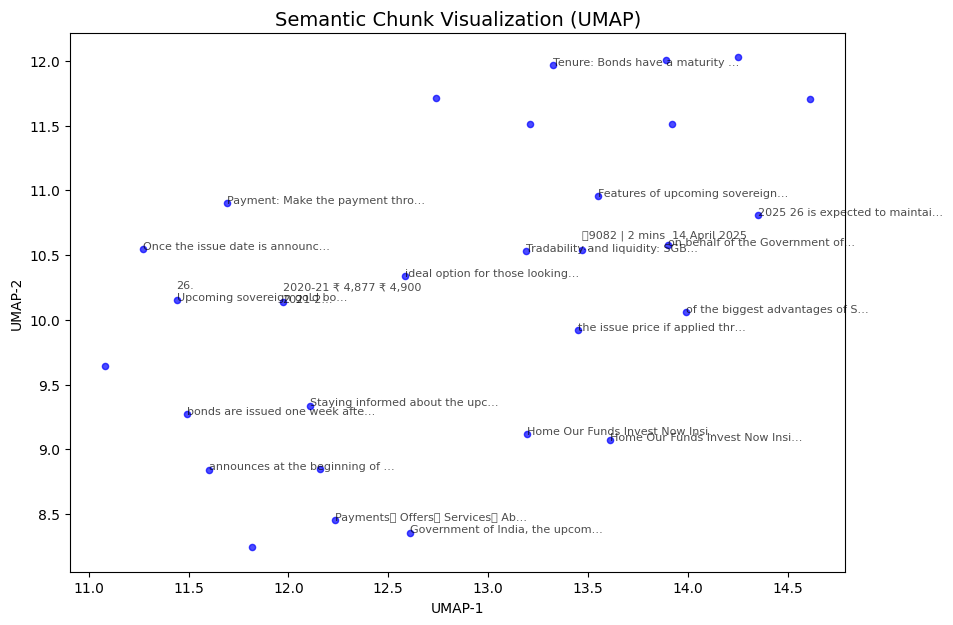

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# ---------------------------
# 1) Collect embeddings + text
# ---------------------------
texts = [doc.page_content for doc in splits]
embs = embeddings.embed_documents(texts)   # shape: [N, D]

# ---------------------------
# 2) Dimensionality reduction
# ---------------------------
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine", random_state=42)
coords = reducer.fit_transform(embs)   # shape: [N, 2]

# ---------------------------
# 3) Matplotlib scatter plot
# ---------------------------
plt.figure(figsize=(10, 7))
plt.scatter(coords[:, 0], coords[:, 1], s=20, alpha=0.7, c="blue")

plt.title("Semantic Chunk Visualization (UMAP)", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Optionally annotate some points with short text previews
for i, txt in enumerate(texts[:20]):  # limit to first 20 to avoid clutter
    plt.annotate(txt[:30] + "…", (coords[i, 0], coords[i, 1]), fontsize=8, alpha=0.7)

plt.show()


Generating embeddings for all text chunks...
Applying t-SNE with perplexity=28 for dimensionality reduction...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Creating the visualization...


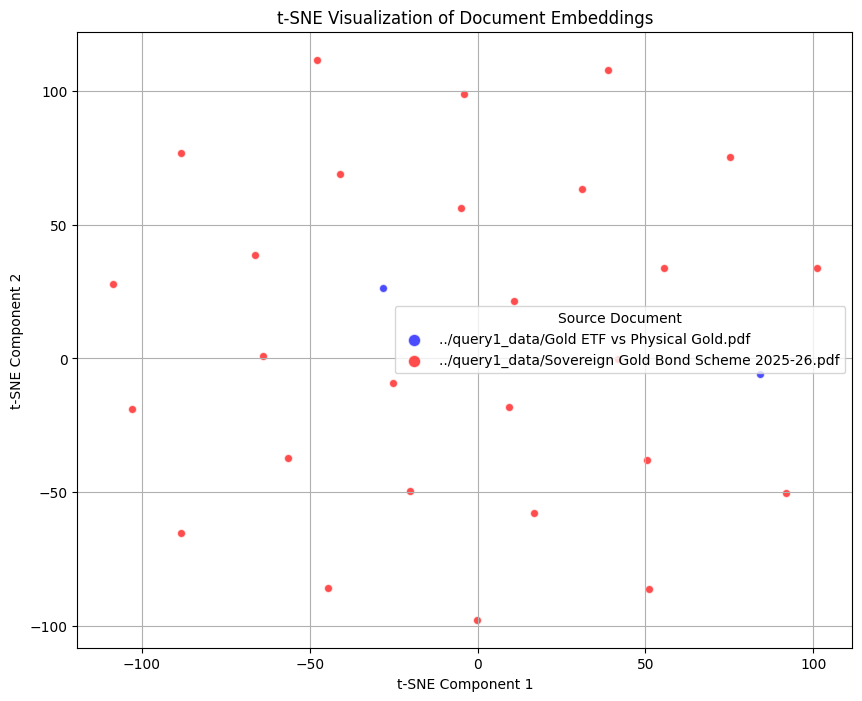

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

def visualize_embeddings(splits, embeddings_model, colors):
    """
    Visualizes the embeddings of text chunks using t-SNE.

    Args:
        splits (list): A list of Document objects from the text splitter.
        embeddings_model: The pre-trained embeddings model.
        colors (list): A list of colors for each document based on its source.
    """
    if not splits:
        print("No text chunks to visualize. Skipping visualization.")
        return

    print("Generating embeddings for all text chunks...")
    # Get the embeddings for all document splits
    texts = [doc.page_content for doc in splits]
    embeddings_list = embeddings_model.embed_documents(texts)
    embeddings_array = np.array(embeddings_list)
    
    n_samples = embeddings_array.shape[0]

    if n_samples <= 1:
        print(f"Cannot visualize with only {n_samples} sample(s). Need more data.")
        return

    # Dynamically set perplexity to be less than the number of samples
    # A common practice is to use min(30, n_samples - 1) for a safe value
    perplexity_val = min(30, n_samples - 1)
    
    print(f"Applying t-SNE with perplexity={perplexity_val} for dimensionality reduction...")
    # Use t-SNE to reduce the embeddings to 2 dimensions for plotting
    tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, init='pca')
    reduced_embeddings = tsne.fit_transform(embeddings_array)

    print("Creating the visualization...")
    # Create a scatter plot of the reduced embeddings
    plt.figure(figsize=(10, 8))

    # Get the file names for the legend
    unique_files = sorted(list(set(doc.metadata.get('source') for doc in splits)))
    color_map = {path: color for path, color in zip(unique_files, colors)}

    for i, doc in enumerate(splits):
        source = doc.metadata.get('source')
        plt.scatter(
            reduced_embeddings[i, 0],
            reduced_embeddings[i, 1],
            c=color_map.get(source, "gray"), # Use .get with a default for safety
            label=source if source not in plt.gca().get_legend_handles_labels()[1] else "",
            alpha=0.7,
            edgecolors='w'
        )
    
    # Add titles and labels for clarity
    plt.title('t-SNE Visualization of Document Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title="Source Document", markerscale=1.5)
    plt.grid(True)
    
    # Show the plot
    plt.show()

# --- Your original RAG code ---
def rag_search(state: dict):
    # 1) Load your PDFs
    pdf_paths = [
        "../query1_data/Gold ETF vs Physical Gold.pdf",
        "../query1_data/Sovereign Gold Bond Scheme 2025-26.pdf"
    ]

    docs = []
    for p in pdf_paths:
        try:
            loader = PyPDFLoader(p)
            # Each page comes with metadata; loader returns Document objects
            docs.extend(loader.load())
        except Exception as e:
            print(f"Error loading {p}: {e}")
            # If files are not found, we cannot proceed
            return {"context": ["Error: PDF files not found. Please ensure the paths are correct."]}

    # 2) Split into chunks (keep overlaps for context continuity)
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=900, chunk_overlap=150, separators=["\n\n", "\n", " ", ""]
    )
    splits = splitter.split_documents(docs)

    # 3) Embeddings (no API key needed)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

    # 4) Build FAISS index
    vecstore = FAISS.from_documents(splits, embeddings)

    # 5) Create a retriever (top_k configurable inside the tool)
    retriever = vecstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

    # Define your query
    query = "What are the benefits of Sovereign Gold Bonds compared to physical gold?"

    # Search for relevant chunks
    retrieved_docs = vecstore.similarity_search(query, k=3)

    # Combine retrieved content
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Now, call the visualization function with the generated splits and embeddings model
    # We will use two colors, one for each PDF
    visualize_embeddings(splits, embeddings, ["blue", "red"])

    return {"context": [context]}

# Example usage (assuming the PDF files are available)
if __name__ == "__main__":
    # Create a dummy state object as required by the function signature
    dummy_state = {}
    rag_search(dummy_state)

Generating embeddings for all text chunks...
Applying t-SNE with perplexity=28 for dimensionality reduction...
Creating the visualization...


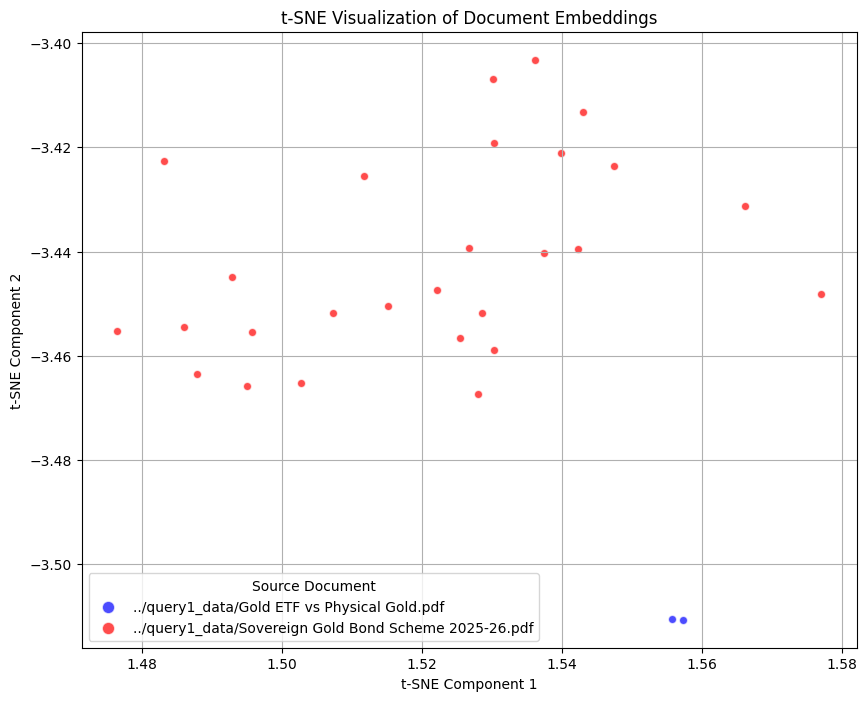

In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

def visualize_embeddings(splits, embeddings_model, colors):
    """
    Visualizes the embeddings of text chunks using t-SNE.

    Args:
        splits (list): A list of Document objects from the text splitter.
        embeddings_model: The pre-trained embeddings model.
        colors (list): A list of colors for each document based on its source.
    """
    if not splits:
        print("No text chunks to visualize. Skipping visualization.")
        return

    print("Generating embeddings for all text chunks...")
    # Get the embeddings for all document splits
    texts = [doc.page_content for doc in splits]
    embeddings_list = embeddings_model.embed_documents(texts)
    embeddings_array = np.array(embeddings_list)
    
    n_samples = embeddings_array.shape[0]

    if n_samples <= 1:
        print(f"Cannot visualize with only {n_samples} sample(s). Need more data.")
        return

    # Dynamically set perplexity to be less than the number of samples
    # A common practice is to use min(30, n_samples - 1) for a safe value
    perplexity_val = min(30, n_samples - 1)
    
    print(f"Applying t-SNE with perplexity={perplexity_val} for dimensionality reduction...")
    # Use t-SNE to reduce the embeddings to 2 dimensions for plotting
    tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42, init='pca')
    reduced_embeddings = tsne.fit_transform(embeddings_array)

    print("Creating the visualization...")
    # Create a scatter plot of the reduced embeddings
    plt.figure(figsize=(10, 8))

    # Get the file names for the legend
    unique_files = sorted(list(set(doc.metadata.get('source') for doc in splits)))
    color_map = {path: color for path, color in zip(unique_files, colors)}

    for i, doc in enumerate(splits):
        source = doc.metadata.get('source')
        plt.scatter(
            reduced_embeddings[i, 0],
            reduced_embeddings[i, 1],
            c=color_map.get(source, "gray"), # Use .get with a default for safety
            label=source if source not in plt.gca().get_legend_handles_labels()[1] else "",
            alpha=0.7,
            edgecolors='w'
        )
    
    # Add titles and labels for clarity
    plt.title('t-SNE Visualization of Document Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title="Source Document", markerscale=1.5)
    plt.grid(True)
    
    # Show the plot
    plt.show()

# --- Your original RAG code ---
def rag_search(state: dict):
    # 1) Load your PDFs
    pdf_paths = [
        "../query1_data/Gold ETF vs Physical Gold.pdf",
        "../query1_data/Sovereign Gold Bond Scheme 2025-26.pdf"
    ]

    docs = []
    for p in pdf_paths:
        try:
            loader = PyPDFLoader(p)
            # Each page comes with metadata; loader returns Document objects
            docs.extend(loader.load())
        except Exception as e:
            print(f"Error loading {p}: {e}")
            # If files are not found, we cannot proceed
            return {"context": ["Error: PDF files not found. Please ensure the paths are correct."]}

    # 2) Split into chunks (keep overlaps for context continuity)
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=900, chunk_overlap=150, separators=["\n\n", "\n", " ", ""]
    )
    splits = splitter.split_documents(docs)

    # 3) Embeddings (no API key needed)
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

    # 4) Build FAISS index
    vecstore = FAISS.from_documents(splits, embeddings)

    # 5) Create a retriever (top_k configurable inside the tool)
    retriever = vecstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

    # Define your query
    query = "What are the benefits of Sovereign Gold Bonds compared to physical gold?"

    # Search for relevant chunks
    retrieved_docs = vecstore.similarity_search(query, k=3)

    # Combine retrieved content
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Now, call the visualization function with the generated splits and embeddings model
    # We will use two colors, one for each PDF
    visualize_embeddings(splits, embeddings, ["blue", "red"])

    return {"context": [context]}

# Example usage (assuming the PDF files are available)
if __name__ == "__main__":
    # Create a dummy state object as required by the function signature
    dummy_state = {}
    rag_search(dummy_state)

In [13]:
# Define your query
query = "Should I allocate more to equity or debt in my portfolio if I’m planning to buy a house in 10 years?"

# Search for relevant chunks
retrieved_docs = vecstore.similarity_search(query, k=3)

# Combine retrieved content
context = "\n\n".join([doc.page_content for doc in retrieved_docs])

print(context)


Recommended Asset Allocation (General Rule of Thumb)
This is based on the age-old 100 minus age rule, adjusted for your goal rather than your age.
Why Equity Should Dominate
Pros:
• Historically, Indian equity returns average 12–15% p.a. over 10 years.
• Ideal for longer horizons: gives you time to ride out market volatility.
• Helps build a bigger corpus faster than debt instruments.
How to Invest:
• SIP in diversiﬁed equity mutual funds (e.g. large-cap, ﬂexi-cap, ELSS if tax saving).
• Consider index funds or ETFs if you want lower cost.
Why Debt Still Matters
Role:
• Adds stability to your portfolio.
• Helps protect capital as you near the goal.
• Rebalances volatility during market downturns.
How to Invest:
• Debt mutual funds (short-term, target maturity funds).
• PPF, EPF (if available), ﬁxed deposits for part of the amount.
Glide Path Strategy (Dynamic Rebalancing)

This ensures your house down payment is protected from late-stage market crashes.
Quick Illustration (₹10,000/mont